# Developing `load_era5()` function from Google

Guidance from https://github.com/google-research/arco-era5/blob/main/docs/0-Surface-Reanalysis-Walkthrough.ipynb

In [1]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

from datacube.utils.geometry import assign_crs

## Load reanalysis

In [2]:
import xarray as xr
import scipy.spatial
import numpy as np

def mirror_point_at_360(ds):
    extra_point = (
      ds.where(ds.longitude == 0, drop=True)
      .assign_coords(longitude=lambda x: x.longitude + 360)
  )
    return xr.concat([ds, extra_point], dim='values')

def build_triangulation(x, y):
    grid = np.stack([x, y], axis=1)
    return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
    indices = tri.find_simplex(mesh)
    ndim = tri.transform.shape[-1]
    T_inv = tri.transform[indices, :ndim, :]
    r = tri.transform[indices, ndim, :]
    c = np.einsum('...ij,...j', T_inv, mesh - r)
    c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
    result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
    return np.where(indices == -1, np.nan, result)

def lon_to_360(dlon: float) -> float:
    return ((360 + (dlon % 360)) % 360)


def load_era5_g(
    var, lat, lon, time,
    reduce_func=None,
    resample="1D",
):
    """
    Download and return an ERA5 variable for a defined time window.

    Parameters
    ----------
    var : string
        Name of the ERA5 climate variable to download, e.g "air_temperature_at_2_metres"

    lat: tuple or list
        Latitude range for query.

    lon: tuple or list
        Longitude range for query.

    time: string or datetime object or a list or tuple of strings or datetime objects
        Used to define starting and end date dates of the time window.

    reduce_func: numpy function
        lets you specify a function to apply to each day's worth of data.
        The default is np.mean, which computes daily average. To get a sum, use np.sum.

    resample: string
        Temporal resampling frequency to be used for xarray's resample function.
        The default is '1D', which is daily.
        Since this is applied on monthly ERA5 data, maximum resampling period is '1M'.

    Returns
    -------
    A lazy-loaded xarray dataset containing an ERA5 variable for the selected region and time window.

    """
    
#   constrain query to available variables
    ERA5_VARS = ['air_pressure_at_mean_sea_level',
                 'air_temperature_at_2_metres',
                 'dew_point_temperature_at_2_metres',
                 'eastward_wind_at_100_metres',
                 'eastward_wind_at_10_metres',
                 'northward_wind_at_100_metres',
                 'northward_wind_at_10_metres',
                 'precipitation_amount_1hour_Accumulation',
                 'sea_surface_temperature',
                 'surface_air_pressure']

    assert var in ERA5_VARS, "var must be one of [{}] (got {})".format(
        ",".join(ERA5_VARS), var
    )
    
    # process date range
    if type(time) in [list, tuple]:
        date_from = np.datetime64(min(time)).astype('datetime64[D]')
        date_to = (np.datetime64(max(time))+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    elif type(time) in [str, np.datetime64]:
        date_from = np.datetime64(time).astype('datetime64[D]')
        date_to = (np.datetime64(time)+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    else:
        raise(ValueError)

    ERA5_dict = {'air_pressure_at_mean_sea_level':'msl',
                 'air_temperature_at_2_metres':'t2m',
                 'dew_point_temperature_at_2_metres':'2d',
                 'eastward_wind_at_100_metres':'100u',
                 'eastward_wind_at_10_metres':'10u',
                 'northward_wind_at_100_metres':'100v',
                 'northward_wind_at_10_metres':'10v',
                 'precipitation_amount_1hour_Accumulation':'tp',
                 'sea_surface_temperature':'sst',
                 'surface_air_pressure':'sp',
                 'skin temperature':'skt'}
    

    if ERA5_dict[var] == 'tp':
        url = 'gs://gcp-public-data-arco-era5/co/single-level-forecast.zarr-v2'
    else:
        url = 'gs://gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2'

    if reduce_func is None:
            reduce_func = np.mean
    
    if ERA5_dict[var] == 'tp':
        ds = xr.open_zarr(
            url, 
            chunks={'time': 48},
            consolidated=True).sel(time=slice(date_from, date_to), step='03:00:00')[[ERA5_dict[var]]].compute()      
    else:
        ds = xr.open_zarr(
            url, 
            chunks={'time': 48},
            consolidated=True).sel(time=slice(date_from, date_to))[[ERA5_dict[var]]].compute()
    
    ds = ds.pipe(mirror_point_at_360)
    
    tri = build_triangulation(ds.longitude, ds.latitude)
    
    longitude = np.linspace(0, 360, num=360*4+1)
    latitude = np.linspace(-90, 90, num=180*4+1)
    mesh = np.stack(np.meshgrid(longitude, latitude, indexing='ij'), axis=-1)
    ds_mesh = interpolate(ds[ERA5_dict[var]].values, tri, mesh)
    ds = xr.DataArray(ds_mesh, name=ERA5_dict[var],
                             coords=[('time', ds.time.data),
                                     ('lon', lon_to_360(longitude)),
                                     ('lat', latitude), 
                                    ]).sortby('lon')
    
#     print('pass')
    ds = ds.sel(lon=slice(lon[0], lon[1]), lat=slice(lat[0],lat[1]))
    ds = ds.resample(time=resample).reduce(reduce_func)
    
    return assign_crs(ds.rename(var).to_dataset(), 'EPSG:4326')

In [3]:
lat = (-37, 5)
lon = (-10, 56)

time = '2021-01-01', '2021-01-05'

In [4]:
var = 'precipitation_amount_1hour_Accumulation'

precip = load_era5_g(var, lat, lon, time, reduce_func=np.mean, resample="1D").compute()

precip

<xarray.Dataset>
Dimensions:                                  (lon: 226, lat: 169, time: 4)
Coordinates:
  * lon                                      (lon) float64 0.0 0.0 ... 56.0
  * lat                                      (lat) float64 -37.0 -36.75 ... 5.0
  * time                                     (time) datetime64[ns] 2021-01-01...
    spatial_ref                              int32 4326
Data variables:
    precipitation_amount_1hour_Accumulation  (time, lon, lat) float64 2.969e-...
Attributes:
    grid_mapping:  spatial_ref

## Alternative load function using analysis ready (`ar`) data 

This may be easier because it does not require transformation of projection etc.

The variables available are slightly different, but include the important & most used ones (wind at 10m, 2m air temp, and precipitation). Further reading at https://cloud.google.com/storage/docs/public-datasets/era5

In [5]:
def load_era5_g_2(
    var, lat, lon, time,
    reduce_func=None,
    resample="1D",
):
    """
    Download and return an ERA5 variable for a defined time window.

    Parameters
    ----------
    var : string
        Name of the ERA5 climate variable to download, e.g "air_temperature_at_2_metres"

    lat: tuple or list
        Latitude range for query.

    lon: tuple or list
        Longitude range for query.

    time: string or datetime object or a list or tuple of strings or datetime objects
        Used to define starting and end date dates of the time window.

    reduce_func: numpy function
        lets you specify a function to apply to each day's worth of data.
        The default is np.mean, which computes daily average. To get a sum, use np.sum.

    resample: string
        Temporal resampling frequency to be used for xarray's resample function.
        The default is '1D', which is daily.
        Since this is applied on monthly ERA5 data, maximum resampling period is '1M'.

    Returns
    -------
    A lazy-loaded xarray dataset containing an ERA5 variable for the selected region and time window.

    """

    #   constrain query to available variables
    ERA5_VARS = ['air_pressure_at_mean_sea_level',
                 'air_temperature_at_2_metres',
                 'eastward_wind_at_10_metres',
                 'northward_wind_at_10_metres',
                 'total_precipitation_6hr',
                 'total_precipitation_12hr',
                 'total_precipitation_24hr',
                 'sea_surface_temperature',
                 'surface_air_pressure']

    assert var in ERA5_VARS, "var must be one of [{}] (got {})".format(
        ",".join(ERA5_VARS), var
    )
    
    # process date range
    if type(time) in [list, tuple]:
        date_from = np.datetime64(min(time)).astype('datetime64[D]')
        date_to = (np.datetime64(max(time))+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    elif type(time) in [str, np.datetime64]:
        date_from = np.datetime64(time).astype('datetime64[D]')
        date_to = (np.datetime64(time)+1).astype('datetime64[D]')-np.timedelta64(1,'D')
    else:
        raise(ValueError)

    ERA5_dict = {'air_pressure_at_mean_sea_level':'mean_sea_level_pressure',
                 'air_temperature_at_2_metres':'2m_temperature',
                 'dew_point_temperature_at_2_metres':'2d',
                 'eastward_wind_at_10_metres':'10m_u_component_of_wind',
                 'northward_wind_at_10_metres':'10m_v_component_of_wind',
                 'total_precipitation_6hr': 'total_precipitation_6hr',
                 'total_precipitation_12hr': 'total_precipitation_12hr',
                 'total_precipitation_24hr':'total_precipitation_24hr',
                 'sea_surface_temperature':'sea_surface_temperature',
                 'surface_air_pressure':'surface_pressure'}
     
    if reduce_func is None:
            reduce_func = np.mean
    
    ds = xr.open_zarr(
            'gs://gcp-public-data-arco-era5/ar/1959-2022-wb13-6h-0p25deg-chunk-1.zarr-v2', 
            chunks={'time': 48},
            consolidated=True)[ERA5_dict[var]].sel(time=slice(date_from, date_to))

    ds = ds.assign_coords(
            longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude').sel(latitude=slice(lat[1], lat[0]), longitude = slice(lon[0], lon[1]))
    ds = ds.resample(time=resample).reduce(reduce_func)

    return assign_crs(ds.to_dataset(), 'EPSG:4326')

In [6]:
lat = (-40, 40)
lon = (-25, 59)

time = '2021-01-01', '2021-04-05'

var = 'air_temperature_at_2_metres'

temp = load_era5_g_2(var, lat, lon, time, reduce_func=np.mean, resample="1M").compute()

temp

<xarray.Dataset>
Dimensions:         (latitude: 321, longitude: 337, time: 4)
Coordinates:
  * latitude        (latitude) float32 40.0 39.75 39.5 ... -39.5 -39.75 -40.0
  * longitude       (longitude) float32 -25.0 -24.75 -24.5 ... 58.5 58.75 59.0
  * time            (time) datetime64[ns] 2021-01-31 2021-02-28 ... 2021-04-30
    spatial_ref     int32 4326
Data variables:
    2m_temperature  (time, latitude, longitude) float32 288.7 288.6 ... 289.3
Attributes:
    grid_mapping:  spatial_ref

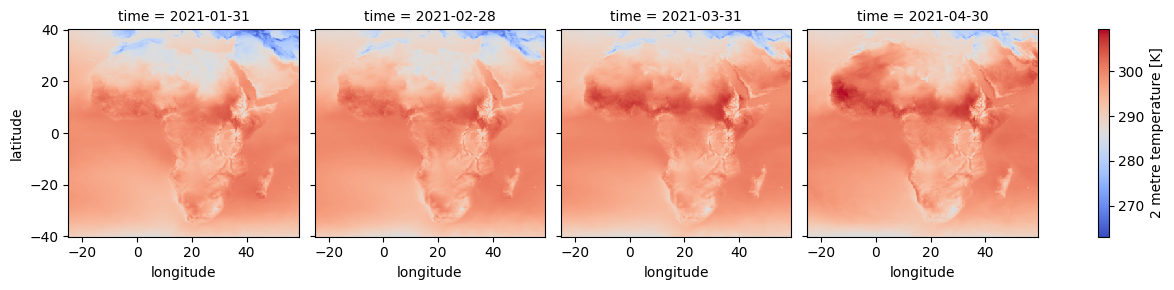

In [7]:
temp['2m_temperature'].plot(col='time', cmap='coolwarm')

## Next steps

1. Assign spatial dimensions and crs to xarray dataset
2. Wrap up in `load_era5()` function.